# Convert model to SNPE

[Set up snpe](https://developer.qualcomm.com/sites/default/files/docs/snpe/setup.html)
```
export LD_LIBRARY_PATH=$LD_LIBRARY_PATH:/home/yeliu/anaconda3/envs/py36/lib
export ANDROID_NDK_ROOT=/opt/android-sdk/ndk
SNPE_PATH=/home/yeliu/Downloads/dep/snpe-2.10.0.4541
source ${SNPE_PATH}/bin/envsetup.sh -p /home/yeliu/anaconda3/envs/py36/lib/python3.6/site-packages/torch
```

(need to update the Silu modules in the original model)

In [2]:
from ultralytics import YOLO
from PIL import Image
from yolo_utils import update_silu_in_model
import cv2
import glob
import torch
import numpy as np

transform YOLO : https://github.com/ultralytics/ultralytics

In [5]:
# https://github.com/ultralytics/ultralytics

# Load a model
model_dict = YOLO("../models/yolo/yolov8n.pt")  # load a pretrained model (recommended for training)

cnt = 0
for sub_network in model_dict.model.model:
    print(cnt, sub_network.__class__.__name__)
    cnt = cnt + 1
    update_silu_in_model(sub_network)
    
# Export the model to TorchScript format
model_dict.export(format='torchscript')  # creates 'yolov8n.torchscript'

0 Conv
1 Conv
2 C2f
3 Conv
4 C2f
5 Conv
6 C2f
7 Conv
8 C2f
9 SPPF
10 Upsample
11 Concat
12 C2f
13 Upsample
14 Concat
15 C2f
16 Conv
17 Concat
18 C2f
19 Conv
20 Concat
21 C2f
22 Detect
Ultralytics YOLOv8.1.27 🚀 Python-3.11.3 torch-2.0.1+cu117 CPU (Intel Core(TM) i7-10750H 2.60GHz)
YOLOv8n summary (fused): 224 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs

PyTorch: starting from '../models/yolo/yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)

TorchScript: starting export with torch 2.0.1+cu117...
TorchScript: export success ✅ 1.1s, saved as '../models/yolo/yolov8n.torchscript' (12.5 MB)

Export complete (2.5s)
Results saved to /home/yeliu/Development/ace/models/yolo
Predict:         yolo predict task=detect model=../models/yolo/yolov8n.torchscript imgsz=640  
Validate:        yolo val task=detect model=../models/yolo/yolov8n.torchscript imgsz=640 data=coco.yaml  
Visualize:       https://netron.app


'../models/yolo/yolov8n.torchscript'

## snpe-pytorch-to-dlc

[convert model to dlc](https://developer.qualcomm.com/sites/default/files/docs/snpe/model_conv_pytorch.html)

```
conda activate py36
```
```
snpe-pytorch-to-dlc --input_network models/yolo/yolov8s.torchscript \
                    --input_dim input "1,3,640,640" \
                    --output_path models/yolo/yolov8s.dlc
```
```
snpe-pytorch-to-dlc --input_network models/yolo/yolov8n.torchscript \
                    --input_dim input "1,3,640,640" \
                    --output_path models/yolo/yolov8n.dlc
```

## snpe-dlc-quantize

https://developer.qualcomm.com/sites/default/files/docs/snpe/model_conversion.html

```
snpe-dlc-quantize --input_dlc models/yolo/yolov8n.dlc --input_list data/image_file_list.txt \
                  --output_dlc models/yolo/yolov8n_quantized.dlc \
                  --axis_quant --use_enhanced_quantizer
```

量化时使用--use_enhanced_quantizer  --axis_quant这个选项精度下降没那么多

In [9]:
import glob
import cv2
import numpy as np

image_paths = glob.glob("/home/yeliu/Development/LidarMapping/data/quantize/*.jpg")

f = open("../data/image_file_list.txt", "w")
for path in image_paths:
    image = cv2.imread(path)
    image = cv2.resize(image, (640, 640)).astype(np.float32) / 255.0
    image = np.transpose(image, (2, 0, 1))
    
    path_np = path.split('.')[0] + ".npy"
    image.tofile(path_np)
    f.write(path_np)
    f.write("\n")
f.close()

# Test transformed model

* 1 - bath size
* 84 - 0,1,2,3 is x,y,width,height, 4,5,6,7,8,9.... probability for each class
* 8400 - number of possible detected objects

In [6]:
import ultralytics
import matplotlib.pyplot as plt


script_module = torch.jit.load("../models/yolo/yolov8n.torchscript")

In [7]:
def plot_image(image_show, preds):
    for i, pred in enumerate(preds):
        pred = pred.cpu().detach().numpy()
        # print(i, pred)
        x1 = int(pred[0] * 480 / 640)
        y1 = int(pred[1])
        x2 = int(pred[2] * 480 / 640)
        y2 = int(pred[3])
        
        color = (0, 255, 0)
        if int(pred[5]) == 56:
            color = (255, 0, 0)
            image_show = cv2.putText(image_show, str(pred[4]), (x1, y1), cv2.FONT_HERSHEY_SIMPLEX ,  
                                1, (255, 0, 255), 2, cv2.LINE_AA)
        image_show = cv2.line(image_show, (x1, y1), (x1, y2), color, 2) 
        image_show = cv2.line(image_show, (x1, y1), (x2, y1), color, 2) 
        image_show = cv2.line(image_show, (x1, y2), (x2, y2), color, 2) 
        image_show = cv2.line(image_show, (x2, y1), (x2, y2), color, 2) 
    return image_show

In [8]:
def test_image(image_path, script_module):
    image_raw = cv2.imread(image_path)
    image_raw = cv2.rotate(image_raw, cv2.ROTATE_90_COUNTERCLOCKWISE)
    image = cv2.resize(image_raw, (640, 640))
    image_tensor = torch.from_numpy(image)
    image_tensor = torch.permute(image_tensor, (2, 0, 1)).unsqueeze(0).float() / 255
    
    results = script_module(image_tensor)
    preds = ultralytics.utils.ops.non_max_suppression(results)[0]
    
    return plot_image(image_raw, preds)

In [11]:
image_paths = glob.glob("../data/car/*.jpg")
image_paths.sort()

for image_path in image_paths:
    image_show = test_image(image_path, script_module)
    save_path = image_path.split(".")[0] + "_yolo.jpg"
    cv2.imwrite(save_path, image_show)

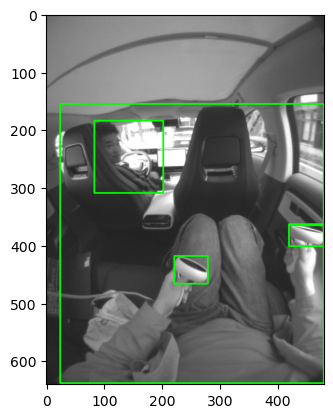

In [12]:
image_show = test_image(image_paths[0], script_module)
plt.imshow(image_show)

# Pytorch to ONNX

#### 2.10

```
snpe-onnx-to-dlc --input_network models/yolo/yolov8n.onnx \
                 --output_path models/yolo/yolov8n_onnx.dlc
```
```
snpe-dlc-quantize --input_dlc models/yolo/yolov8n_onnx.dlc --input_list data/image_file_list.txt \
                  --output_dlc models/yolo/yolov8n_onnx_quantized.dlc \
                  --axis_quant --use_enhanced_quantizer
```

#### 1.6

```
snpe-onnx-to-dlc --input_network models/yolo/yolov8n.onnx \
                 --output_path models/yolo/yolov8n_onnx_16.dlc
```
```
snpe-dlc-quantize --input_dlc models/yolo/yolov8n_onnx_16.dlc --input_list data/image_file_list.txt \
                  --output_dlc models/yolo/yolov8n_onnx_16_quantized.dlc \
                  --axis_quant --use_enhanced_quantizer
```

In [13]:
random_input = torch.randn(1, 3, 640, 640, requires_grad=True)

# Export the model
torch.onnx.export(script_module,             # model being run
                  random_input,              # model input (or a tuple for multiple inputs)
                  "../models/yolo/yolov8n.onnx",   # where to save the model (can be a file or file-like object)
                  export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                  do_constant_folding=True,  # whether to execute constant folding for optimization
                 )

============= Diagnostic Run torch.onnx.export version 2.0.1+cu117 =============
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

